In [1]:
import pandas as pd

In [2]:
df=pd.read_csv('india_thiruvananthapuram_plammoodu_LiveData_preProcessed_AQICalculated.csv')

In [3]:
df.head()

,Date,PM2.5,PM10,O3,NO2,SO2,CO,PM2.5_SubIndex,PM10_SubIndex,SO2_SubIndex,NO2_SubIndex,CO_SubIndex,O3_SubIndex,Checks,AQI_calculated,AQI_bucket_calculated
0,13-11-2017,145.0,65.0,3.0,7.0,2.0,13.0,197,55,2.50,8.75,158,3.0,6,197,Moderate
1,14-11-2017,145.0,61.0,3.0,5.0,2.0,10.0,197,53,2.50,6.25,108,3.0,6,197,Moderate
2,15-11-2017,135.0,62.0,3.0,5.0,1.0,10.0,192,54,1.25,6.25,108,3.0,6,192,Moderate
3,16-11-2017,144.0,54.0,3.0,6.0,2.0,10.0,197,49,2.50,7.50,108,3.0,6,197,Moderate
4,17-11-2017,118.0,65.0,3.0,5.0,2.0,10.0,183,55,2.50,6.25,108,3.0,6,183,Moderate


In [4]:
df.tail()

,Date,PM2.5,PM10,O3,NO2,SO2,CO,PM2.5_SubIndex,PM10_SubIndex,SO2_SubIndex,NO2_SubIndex,CO_SubIndex,O3_SubIndex,Checks,AQI_calculated,AQI_bucket_calculated
1254,20-04-2021,26.0,35.0,11.0,11.0,6.0,7.0,80,32,7.50,13.75,75,11.0,6,80,Satisfactory
1255,21-04-2021,55.0,42.0,15.0,10.0,6.0,6.0,149,38,7.50,12.50,65,15.0,6,149,Moderate
1256,22-04-2021,74.0,36.0,13.0,8.0,7.0,7.0,160,33,8.75,10.00,75,13.0,6,160,Moderate
1257,23-04-2021,61.0,33.0,12.0,9.0,7.0,6.0,153,30,8.75,11.25,65,12.0,6,153,Moderate
1258,24-04-2021,57.0,33.0,8.0,7.0,3.0,6.0,151,30,3.75,8.75,65,8.0,6,151,Moderate


In [5]:
df1=df.reset_index()['AQI_calculated']

In [6]:
df1

0       197
1       197
2       192
3       197
4       183
       ... 
1254     80
1255    149
1256    160
1257    153
1258    151
Name: AQI_calculated, Length: 1259, dtype: int64

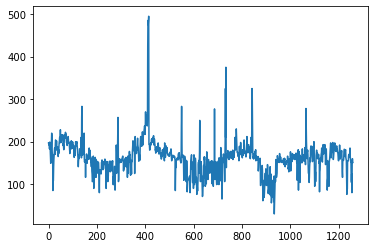

In [7]:
import matplotlib.pyplot as plt
plt.plot(df1)

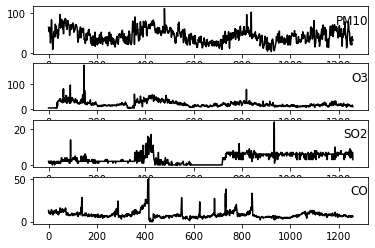

In [8]:
groups = [ 2, 3, 5, 6]
i = 1
plt.figure()
values = df.values
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group],'k')
    plt.title(df.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [9]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler 

In [10]:
import numpy as np

In [11]:
df1

0       197
1       197
2       192
3       197
4       183
       ... 
1254     80
1255    149
1256    160
1257    153
1258    151
Name: AQI_calculated, Length: 1259, dtype: int64

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [13]:
print(df1)

[[0.35913978]
 [0.35913978]
 [0.3483871 ]
 ...
 [0.27956989]
 [0.26451613]
 [0.26021505]]


In [14]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [15]:
training_size,test_size

(818, 441)

In [16]:
# train_data

In [17]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [18]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [19]:
print(X_train.shape)
print(y_train.shape)

(717, 100)
(717,)


In [20]:
print(X_test.shape), print(ytest.shape)

(340, 100)
(340,)


(None, None)

In [21]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [22]:
print(X_train.shape),print(y_train.shape)

(717, 100, 1)
(717,)


(None, None)

In [23]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from keras.utils.vis_utils import plot_model
from keras import metrics

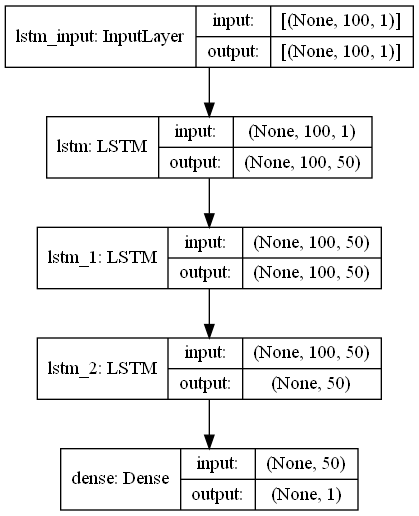

In [24]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam', metrics=[metrics.MeanSquaredError()])
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 7s 262ms/step - loss: 0.0592 - mean_squared_error: 0.0592 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 2/100
12/12 [==============================] - 1s 83ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 3/100
12/12 [==============================] - 1s 81ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 4/100
12/12 [==============================] - 1s 82ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 5/100
12/12 [==============================] - 1s 80ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 6/100
12/12 [==============================] - 1s 82ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 7/100
12/12 [========

In [28]:
import tensorflow as tf

In [29]:
tf.__version__

'2.4.1'

In [30]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [31]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [32]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

166.05732467381642

In [33]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

154.45357004661582

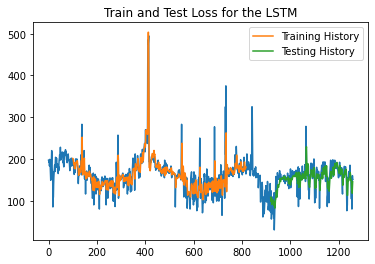

In [34]:
### Plotting 
# shift train predictions for plotting
look_back=time_step
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot, label='Training History')
plt.plot(testPredictPlot, label='Testing History')
plt.title("Train and Test Loss for the LSTM")
plt.legend()
plt.show()

In [37]:
len(test_data)

441

In [38]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
x_input.shape


(1, 100)

In [39]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [40]:
# demonstrate prediction for next X days
from numpy import array

number_of_prediction_days = time_step
lst_output=[]
n_steps=time_step
i=0
while(i<number_of_prediction_days):
    
    if(len(temp_input)>time_step):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        #print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.24875192]
[[0.2487519234418869], [0.23756203055381775], [0.2324289083480835], [0.23475004732608795], [0.2409159541130066], [0.2465389221906662], [0.24905668199062347], [0.24806509912014008], [0.24464088678359985], [0.24045266211032867], [0.2369263619184494], [0.23472116887569427], [0.23371125757694244], [0.23335491120815277], [0.23311662673950195], [0.23270536959171295], [0.2320973128080368], [0.23143424093723297], [0.23089106380939484], [0.23057810962200165], [0.23050673305988312], [0.23060722649097443], [0.23077653348445892], [0.23092298209667206], [0.23099184036254883], [0.23096778988838196], [0.2308623194694519], [0.23069703578948975], [0.2304902970790863], [0.23025162518024445], [0.22998341917991638], [0.22968584299087524], [0.22936125099658966], [0.22901621460914612], [0.22866082191467285], [0.2283066213130951], [0.2279636710882187], [0.22763924300670624], [0.22733727097511292], [0.22705884277820587], [0.22680307924747467], [0.22656823694705963], [0.22635212540626526], [0.2261

In [41]:
day_new=np.arange(1,147)
day_pred=np.arange(147,293)

In [48]:
import matplotlib.pyplot as plt

In [49]:
len(df1)

1259

In [50]:
len(day_pred)

146

In [51]:
len(day_new)

146

ValueError: x and y must have same first dimension, but have shapes (146,) and (100, 1)

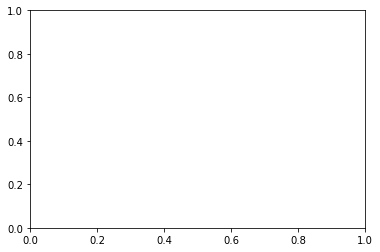

In [62]:
plt.plot(day_new,scaler.inverse_transform(df1[len(df1)-100:]))
# plt.plot(day_new,scaler.inverse_transform(df1)
plt.plot(day_pred, scaler.inverse_transform(lst_output), label= "Predicted Values")
plt.legend()
plt.show()

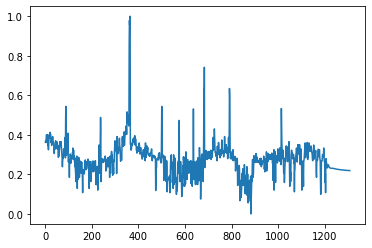

In [56]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[50:])

In [57]:
tmp = scaler.inverse_transform(lst_output)
tmp

array([[145.6696444 ],
       [140.46634421],
       [138.07944238],
       [139.15877201],
       [142.02591866],
       [144.64059882],
       [145.81135713],
       [145.35027109],
       [143.75801235],
       [141.81048788],
       [140.17075829],
       [139.14534353],
       [138.67573477],
       [138.51003371],
       [138.39923143],
       [138.20799686],
       [137.92525046],
       [137.61692204],
       [137.36434467],
       [137.21882097],
       [137.18563087],
       [137.23236032],
       [137.31108807],
       [137.37918667],
       [137.41120577],
       [137.4000223 ],
       [137.35097855],
       [137.27412164],
       [137.17798814],
       [137.06700571],
       [136.94228992],
       [136.80391699],
       [136.65298171],
       [136.49253979],
       [136.32728219],
       [136.16257891],
       [136.00310706],
       [135.852248  ],
       [135.711831  ],
       [135.58236189],
       [135.46343185],
       [135.35423018],
       [135.25373831],
       [135

In [58]:
len(scaler.inverse_transform(lst_output))


100

In [59]:
df3=scaler.inverse_transform(df3).tolist()

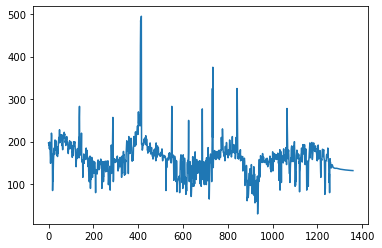

In [60]:
plt.plot(df3)